In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from financepy.utils import *
from financepy.products.rates import *
from tqdm import tqdm
import datetime
import pickle

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



读取处理过的数据，保留数据齐全的数据，调整时间格式

In [3]:
df = pd.read_excel('MicroRV_CW.xlsx')
df.dropna(inplace=True) # dates where all benchmark instruments are available
# convert date to format dd-mm-yyyy
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
# convert to float
df = df.astype(np.float32)

In [6]:
df

,1W,2W,1M,2M,5M,6M,7M,8M,9M,10M,...,8Y,9Y,10Y,12Y,15Y,20Y,25Y,30Y,40Y,50Y
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-27,0.19560,0.38050,0.38050,0.43390,0.61670,0.67380,0.74200,0.79440,0.84270,0.89160,...,1.18400,1.17000,1.15820,1.1314,1.11480,1.06650,1.02200,0.98120,0.89275,0.80450
2022-01-28,0.22930,0.38450,0.38450,0.43750,0.63216,0.69100,0.75890,0.81300,0.86277,0.91184,...,1.20635,1.19205,1.18135,1.1593,1.13870,1.09380,1.05250,1.01580,0.92410,0.83600
2022-01-31,0.33260,0.41175,0.41175,0.47100,0.66400,0.72300,0.79670,0.85310,0.90340,0.95515,...,1.25550,1.23790,1.22800,1.2130,1.18600,1.14400,1.10225,1.06700,0.98105,0.89615
2022-02-01,0.36900,0.42165,0.42165,0.47700,0.66610,0.72550,0.79400,0.85360,0.89930,0.94730,...,1.24800,1.23400,1.22400,1.2038,1.17790,1.13300,1.09200,1.05600,0.96620,0.88300
2022-02-02,0.40855,0.43415,0.43415,0.49000,0.67320,0.72580,0.79080,0.84631,0.89184,0.93803,...,1.22300,1.20800,1.19700,1.1750,1.14700,1.09600,1.05100,1.01100,0.92025,0.83355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-19,4.70180,4.70390,4.71000,4.70410,4.62260,4.59625,4.56487,4.53630,4.51151,4.48554,...,3.97335,3.97900,3.99100,4.0265,4.07392,4.10692,4.09602,4.05797,3.98100,3.86650
2024-11-20,4.70200,4.70390,4.71000,4.70400,4.61850,4.58900,4.55400,4.52600,4.49900,4.47290,...,3.94650,3.95450,3.96800,4.0060,4.05550,4.09050,4.08150,4.04400,3.96646,3.85300
2024-11-21,4.70200,4.70400,4.71000,4.69700,4.59500,4.56280,4.52550,4.49250,4.46300,4.43410,...,3.89800,3.90600,3.91850,3.9560,4.00500,4.03900,4.03096,3.99400,3.94695,3.83185


In [5]:
columns = ['1W','2W']
for i in [1,2,5,6,7,8,9,10,11]:
    columns.append(str(i)+'M')
columns.append('1Y')
columns.append('18M')
for i in [2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50]:
    columns.append(str(i)+'Y')

for old_name, new_name in zip(df.columns, columns):
    df.rename(columns={old_name: new_name}, inplace=True)

将各期限转为年为单位，并构建dictionary

In [7]:
# convert tenors to numpy array in the unit of year
tenors = np.array([1/52, 2/52, 1/12, 2/12, 5/12, 6/12, 7/12, 8/12, 9/12, 10/12, 11/12, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40, 50])
# a dictionary that match column names to tenors
tenors_dict = dict(zip(df.columns, tenors))
# fit a hermite spline to first row with selected tenors
selected_tenors = df.columns[::2] # select some tenors not all to show that the curve is interpolated
x = np.array([tenors_dict[i] for i in selected_tenors])
date = df.index[0]
y = df.loc[date, selected_tenors].values

In [16]:
x

array([1.92307692e-02, 8.33333333e-02, 4.16666667e-01, 5.83333333e-01,
       7.50000000e-01, 9.16666667e-01, 1.50000000e+00, 3.00000000e+00,
       5.00000000e+00, 7.00000000e+00, 9.00000000e+00, 1.20000000e+01,
       2.00000000e+01, 3.00000000e+01, 5.00000000e+01])

In [17]:
y

array([0.1956 , 0.3805 , 0.6167 , 0.742  , 0.8427 , 0.933  , 1.1354 ,
       1.294  , 1.26005, 1.2035 , 1.17   , 1.1314 , 1.0665 , 0.9812 ,
       0.8045 ], dtype=float32)

Text(0, 0.5, 'Rate (%)')

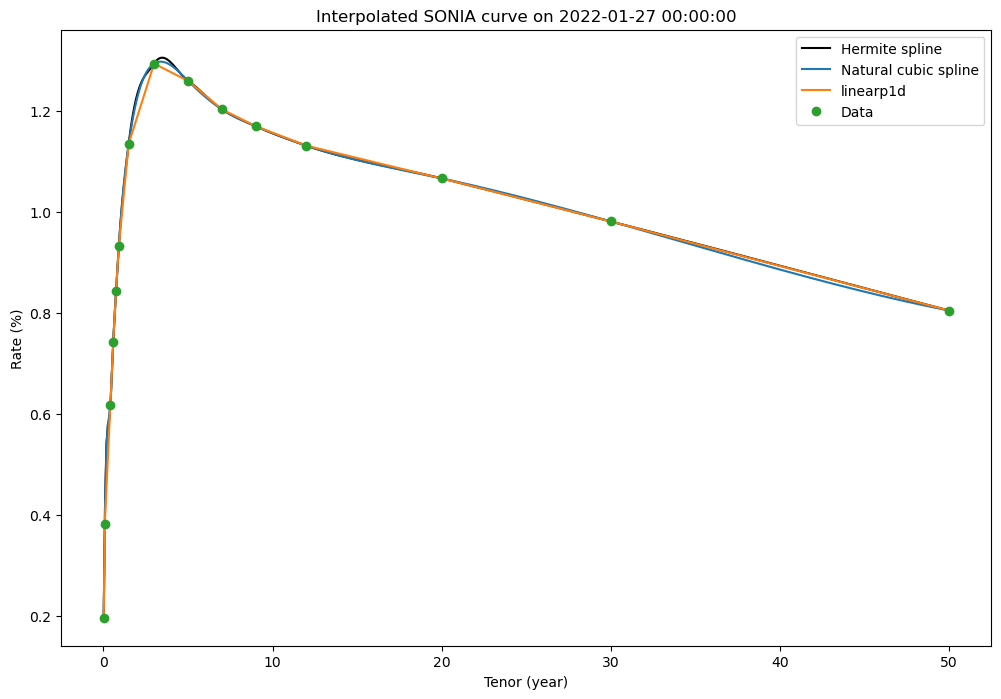

In [9]:
# cubic hermite spline
cs = CubicHermiteSpline(x, y, np.gradient(y, x), axis=0)
# natural cubic spline
cs_natrual = CubicSpline(x, y)
# linear
cs_linear = interp1d(x, y)

# interpolate
xnew = np.arange(1/52,50,1/12) # every month
ynew = cs(xnew)
ynew_natrual = cs_natrual(xnew)
ynew_linear = cs_linear(xnew)
#plot natrual cubic spline
plt.figure(figsize=(12,8))
plt.plot(xnew, ynew, '-', label='Hermite spline',color='black')
plt.plot(xnew, ynew_natrual, '-', label='Natural cubic spline')
plt.plot(xnew, ynew_linear, '-', label='linearp1d')

plt.plot(x,y,'o', label='Data')
plt.xlabel('Tenor (year)')
plt.legend()
plt.title(f'Interpolated SONIA curve on {date}')
plt.ylabel('Rate (%)')

In [10]:
def plotCurve(curve, start_date, tmax, instr_mat_dates_or_tenor = None, title = ''):
    """
    Plots zero rates, ON fwd rates and term fwd rates for a curve
    Inputs:
    curve: IborSingleCurve
    start_date: Date
    tmax: float, max time in years
    instr_mat_dates_or_tenor: None or list of Dates or a tenor string
    title: str, title of the plot
    """
    years = np.linspace(1/365, tmax, int(365*tmax)//30) # split the time into 30 day intervals
    dates = start_date.add_years(years) # the array of end dates for the curve
    zero_rates = curve.zero_rate(dates) # zero_rate
    on_fwd_rates = curve.fwd(dates) # ON fwd rates

    ys_monthly = np.arange(1,tmax*12+1)/12
    monthly_dates = start_date.add_years(ys_monthly)

    if instr_mat_dates_or_tenor is not None:
        # Will plot term forward rates
        # instr_mat_dates_or_tenor could be a list of curve-building
        # isntrument maturities in which case term fwd rates go from the last instrument maturiy date that is less
        # than the plotting date to the plotting date. Or it could be a tenor so that fwd rates cover that tenor 
        # i.e. the term fwd rate for d covers [max(d-tenor,start_date), d]
        # tenor should be a positive tenor

        if isinstance(instr_mat_dates_or_tenor, str):
            neg_tenor = '-' + instr_mat_dates_or_tenor
            start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
            start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
            fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'
        else:
            instr_mat_dates_or_tenor = [start_date] + instr_mat_dates_or_tenor
            start_fwd_dates = [ max([md  for md in instr_mat_dates_or_tenor if md < d]) for d in dates]
            fwd_rate_label = 'term fwd rates from prev instr mtrty'

        term_fwd_rates = curve.fwd_rate(start_fwd_dates, dates)

    plt.figure(figsize=(8,6))
    plt.plot(years, zero_rates*100, '-', label="zero rates")
    plt.plot(years, on_fwd_rates*100, '-', label = "ON fwd rates")

    if instr_mat_dates_or_tenor is not None:
        plt.plot(years, term_fwd_rates*100, '.', label = fwd_rate_label)

    plt.xlabel("Times in years")
    plt.ylabel("Rates (%) - See Legend")
    plt.title(title)
    plt.legend()

In [11]:
# Demonstrate fitting a curve using the first date
valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
spot_days = 0 # T+0 as shown in Bloomberg ticker
settlement_date = valuation_date.add_weekdays(spot_days)
cal = CalendarTypes.UNITED_KINGDOM
# store SONIA swap as we only have swap as benchmark instruments
swaps = []
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F # 365 fixed

for tenor in df.columns:
   if tenor[-1]=='Y': # only append yearly tenors for swap
      rate = df.loc[df.index[0], tenor]/100 # convert to %
      swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                      fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                      float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
      swaps.append(swap)

不太确定下面InterpTypes是FINCUBIC_ZERO_RATES or NATCUBIC_LOG_DISCOUNT or NATCUBIC_ZERO_RATES

Text(0.5, 1.0, 'Interpolated SONIA curve on 27-01-2022')

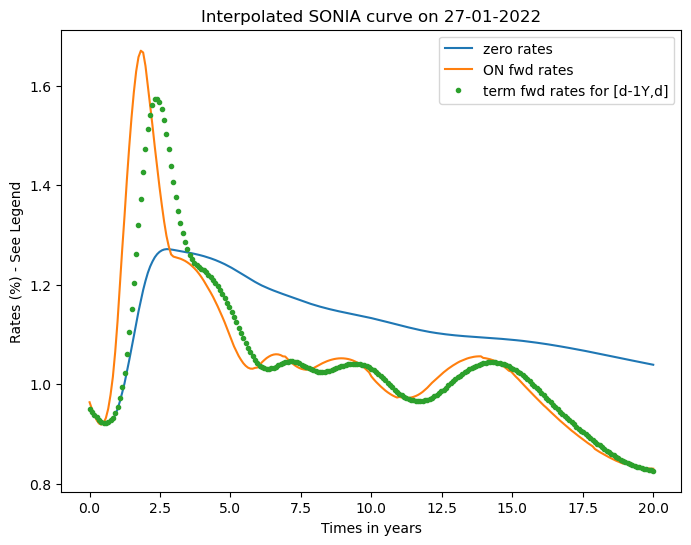

In [12]:
curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.NATCUBIC_ZERO_RATES) 
plotCurve(curve, valuation_date, 20, instr_mat_dates_or_tenor='1Y')
plt.title(f'Interpolated SONIA curve on {df.index[0].strftime("%d-%m-%Y")}')

In [13]:
# create a yield curve dataset with columns in years, and rows same as df.index
# create a curves dictionary to store the calibrated curve for each date
curves = {}
year_columns = list(df.columns[df.columns.str.endswith('Y')]) # list of yearly tenors
year_columns = [int(i[:-1]) for i in year_columns] # convert to int
df_yield = pd.DataFrame(index=df.index, columns=year_columns) # 1y to 25y
# swap characteristics
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F # 365 fixed

for date in tqdm(df.index, desc='Creating curves'): # loop through each date in the dataset
    swaps = []
    day, month, year = date.day, date.month, date.year
    valuation_date = Date(day, month, year) # convet to Date object
    spot_days = 0 # T+0
    settlement_date = valuation_date.add_weekdays(spot_days)
    for tenor in df.columns: # loop through each tenor in the dataset
        if tenor[-1]=='Y':
            rate = df.loc[date, tenor]/100
            swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                            fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
            swaps.append(swap)

    curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.NATCUBIC_ZERO_RATES)
    for year in year_columns:
        df_yield.loc[date, year] = curve.swap_rate(effective_dt=valuation_date,maturity_dt=valuation_date.add_years(year))
    curves[date] = curve # add this curve to the dictionary

Creating curves: 100%|██████████| 716/716 [07:51<00:00,  1.52it/s]


### butterfly

In [ ]:
# z = 2 * rb - ra - rc
def compute_fly_from_curves(curves, fly_legs, window=60, rate_type='zero'):
    """
    根据已拟合好的 financepy curves，计算给定 butterfly 结构的 fly spread 和 z-score。

    参数:
    - curves: dict[Date] → IborSingleCurve
    - fly_legs: list of (a,b,c) tuples，代表不同的 fly 结构（单位：年）
    - window: 滚动窗口长度（单位：天数）
    - rate_type: 'zero' 或 'forward'，表示从 curve 中提取哪种利率计算 fly

    返回:
    - fly_df: 每天每个结构的 fly spread
    - zscore_df: 每天每个结构的 z-score
    """

    fly_data = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs}
    zscore_data = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs}
    dates = list(curves.keys())
    dates.sort()

    for idx in range(window, len(dates)):
        current_date = dates[idx]
        current_curve = curves[current_date]

        past_fly_dict = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs}

        # 过去窗口内的 fly spread 序列
        for hist_date in dates[idx - window: idx]:
            hist_curve = curves[hist_date]
            for (a, b, c) in fly_legs:
                d_a = Date(hist_date.day, hist_date.month, hist_date.year).add_years(a)
                d_b = Date(hist_date.day, hist_date.month, hist_date.year).add_years(b)
                d_c = Date(hist_date.day, hist_date.month, hist_date.year).add_years(c)

                if rate_type == 'zero':
                    try:
                        ra = hist_curve.zero_rate(d_a)
                        rb = hist_curve.zero_rate(d_b)
                        rc = hist_curve.zero_rate(d_c)
                    except:
                        continue
                elif rate_type == 'forward':
                    try:
                        ra = hist_curve.fwd(d_a)
                        rb = hist_curve.fwd(d_b)
                        rc = hist_curve.fwd(d_c)
                    except:
                        continue
                else:
                    raise ValueError("rate_type must be 'zero' or 'forward'")

                fly_hist = 2 * rb - ra - rc
                past_fly_dict[f"{a}-{b}-{c}"].append(fly_hist)

        # 当前日期的 fly 和 z-score
        for (a, b, c) in fly_legs:
            d_a = Date(current_date.day, current_date.month, current_date.year).add_years(a)
            d_b = Date(current_date.day, current_date.month, current_date.year).add_years(b)
            d_c = Date(current_date.day, current_date.month, current_date.year).add_years(c)

            try:
                if rate_type == 'zero':
                    ra = current_curve.zero_rate(d_a)
                    rb = current_curve.zero_rate(d_b)
                    rc = current_curve.zero_rate(d_c)
                else:
                    ra = current_curve.fwd(d_a)
                    rb = current_curve.fwd(d_b)
                    rc = current_curve.fwd(d_c)

                fly_today = 2 * rb - ra - rc
                fly_data[f"{a}-{b}-{c}"].append(fly_today)

                hist_vals = past_fly_dict[f"{a}-{b}-{c}"]
                if len(hist_vals) >= 5:
                    mu = np.mean(hist_vals)
                    sigma = np.std(hist_vals)
                    z = (fly_today - mu) / sigma if sigma > 1e-6 else 0
                else:
                    z = np.nan
                zscore_data[f"{a}-{b}-{c}"].append(z)
            except:
                fly_data[f"{a}-{b}-{c}"].append(np.nan)
                zscore_data[f"{a}-{b}-{c}"].append(np.nan)

    fly_df = pd.DataFrame(fly_data, index=dates[window:])
    zscore_df = pd.DataFrame(zscore_data, index=dates[window:])
    return fly_df, zscore_df

In [98]:
fly_legs = [(2, 5, 10), (5, 10, 30), (3, 5, 7)]
kmonths = 60 #day, 相当于3个月
fly_df_forward, z_df_forward = compute_fly_from_curves(curves, fly_legs, window=kmonths, rate_type='forward') 

In [99]:
def select_best_trades(criteria_computed,N=10):
    z_flat = criteria_computed.stack().dropna()  # 把 z_df 转成长表
    return z_flat[z_flat.abs().sort_values(ascending=False).head(N).index] # 按照绝对值排序

best_10_trades = select_best_trades(z_df_forward,10)
best_10_trades

2024-07-30  3-5-7      6.710904
2024-09-06  3-5-7      6.249900
2022-09-27  5-10-30   -6.113258
2022-06-22  5-10-30    6.087875
2022-09-28  3-5-7     -5.918006
2022-04-22  2-5-10    -5.372877
2024-10-03  3-5-7     -5.243586
2022-09-29  5-10-30    5.107156
2022-09-27  2-5-10     5.104727
2022-06-22  2-5-10    -4.966665
dtype: float64

In [100]:
def simulate_fly_pnl_dv01(start_date, structure, curves, notional=1e6):
    """
    基于 swap DV01 模拟 fly spread 的 PnL
    
    参数:
    - start_date: 信号触发日期（开仓）
    - structure: tuple (a,b,c)，表示 fly: 2b - a - c
    - curves: dict[pd.Timestamp] → IborSingleCurve
    - notional: 每条leg的名义本金，默认 100 万
    
    返回:
    - pnl_series: 每天的 fly 结构的累计 PnL
    - leg_pnls: 每条leg的单独 PnL 路径
    """
    a, b, c = structure
    all_dates = sorted([d for d in curves if d >= start_date])
    if len(all_dates) == 0:
        return None, None

    # 起始日期 & 每条leg的 maturity
    d0 = start_date
    d0_date = Date(d0.day, d0.month, d0.year)
    mty_a = d0_date.add_years(a)
    mty_b = d0_date.add_years(b)
    mty_c = d0_date.add_years(c)

    curve_0 = curves[d0]
    
    def swap_dv01(curve, start_date, maturity_date):
        """根据贴现现金流估算 swap DV01"""
        try:
            tau = 1  # annual accrual
            d = start_date.add_years(1)
            payment_dates = []
            while d <= maturity_date:
                payment_dates.append(d)
                d = d.add_years(1)
            discount_factors = [curve.df(p) for p in payment_dates]
            return sum(tau * df for df in discount_factors)
        except:
            return np.nan

    # 开仓时每条leg的 swap rate 和 DV01
    legs = {
        'a': {'mty': mty_a, 'sign': -1},
        'b1': {'mty': mty_b, 'sign': 2},
        'c': {'mty': mty_c, 'sign': -1},
    }

    for key, leg in legs.items():
        leg['rate_open'] = curve_0.swap_rate(d0_date, leg['mty'])
        leg['dv01'] = swap_dv01(curve_0, d0_date, leg['mty'])

    # 模拟持仓期间的每日 PnL
    pnl_data = {k: [] for k in legs}
    total_pnl = []

    for d in all_dates:
        curve = curves[d]
        d_date = Date(d.day, d.month, d.year)
        daily_pnl = 0
        for key, leg in legs.items():
            try:
                rate_now = curve.swap_rate(d_date, leg['mty']) #maturity在变，attention！
                rate_diff = rate_now - leg['rate_open']
                leg_pnl = float(rate_diff * leg['dv01'] * notional * leg['sign'])
                pnl_data[key].append(leg_pnl)
                daily_pnl += leg_pnl
            except:
                pnl_data[key].append(np.nan)
                daily_pnl = np.nan
        total_pnl.append(daily_pnl)

    pnl_series = pd.Series(total_pnl, index=all_dates)
    leg_pnls = pd.DataFrame(pnl_data, index=all_dates)
    return pnl_series, leg_pnls

In [102]:
def backtest_top_n_fly_trades_dv01(top_signals, curves, notional=1e6):
    """
    使用 DV01 精确计算每个交易的 PnL

    参数：
    - top_signals: 选出来的top trades
    - curves: dict[pd.Timestamp] → IborSingleCurve
    - notional: 每条leg的名义本金

    返回：
    - result_df: 每笔交易的明细
    - summary: 总结
    """
    records = []

    for (date, structure_str) in top_signals.index:
        z_score = top_signals.loc[date, structure_str]
        structure = tuple(map(int, structure_str.split('-')))
        direction = -1 if z_score > 0 else 1  # 正z做空fly，负z做多fly

        try:
            pnl_series, leg_pnls = simulate_fly_pnl_dv01(date, structure, curves, notional=notional)
            if pnl_series is None or pnl_series.dropna().empty:
                continue

            adjusted_pnl = direction * pnl_series
            final_pnl = adjusted_pnl.dropna().iloc[-1] #到期or最后一天pnl
            max_drawdown = (adjusted_pnl.cummax() - adjusted_pnl).max()

            records.append({
                'start_date': date,
                'structure': structure_str,
                'z_score': z_score,
                'direction': 'short fly' if z_score > 0 else 'long fly',
                'final_pnl': final_pnl,
                'max_drawdown': max_drawdown,
                'duration': len(adjusted_pnl)
            })
        except Exception as e:
            continue

    result_df = pd.DataFrame(records)
    summary = {
        'Total Trades': len(result_df),
        'Win Ratio': (result_df['final_pnl'] > 0).mean(),
        'Average PnL': result_df['final_pnl'].mean(),
        'Average Max Drawdown': result_df['max_drawdown'].mean(),
        'Average Duration': result_df['duration'].mean()
    }
    return result_df, summary

In [104]:
result, summary = backtest_top_n_fly_trades_dv01(best_10_trades, curves, notional=1e6)

C:\Users\10317\AppData\Local\Temp\ipykernel_53656\3732739159.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  leg_pnl = float(rate_diff * leg['dv01'] * notional * leg['sign'])


In [105]:
result

,start_date,structure,z_score,direction,final_pnl,max_drawdown,duration
0,2024-07-30,3-5-7,6.710904,short fly,-1202.108450,3794.922449,85
1,2024-09-06,3-5-7,6.249900,short fly,-1525.246733,3357.209238,57
2,2022-09-27,5-10-30,-6.113258,long fly,-56079.933399,142863.158006,550
3,2022-06-22,5-10-30,6.087875,short fly,183853.574047,141212.411266,616
4,2022-09-28,3-5-7,-5.918006,long fly,-31129.239538,46289.209607,549
5,2022-04-22,2-5-10,-5.372877,long fly,-3693.121028,75455.648884,656
6,2024-10-03,3-5-7,-5.243586,long fly,547.859950,1320.602209,38
7,2022-09-29,5-10-30,5.107156,short fly,33903.046651,92870.048200,548
8,2022-09-27,2-5-10,5.104727,short fly,83150.552482,62587.554583,550
9,2022-06-22,2-5-10,-4.966665,long fly,20025.907500,96975.094418,616


In [ ]:
summary #duration感觉应该也没啥用？

{'Total Trades': 10,
 'Win Ratio': 0.5,
 'Average PnL': 22785.129148313135,
 'Average Max Drawdown': 66672.58588596561,
 'Average Duration': 426.5}